# Analyzing NYC High School Data

## Introduction

In this project, we'll explore relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the [SAT](en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.s. take every year. The SAT has three sections, each of which is worth a maximum of `800` points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school. 

New York City has published data on [student SAT scores](data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets:
- `SAT scores by school` - SAT scores for each high school in New York City
- `School attendance` - Attendance information for each school in New York City
- `Class size` - Information on class size for each school
- `AP test results` - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- `Graduation outcomes` - The percentage o students who graduated, and other outcome information
- `Demographics` - Demographic information for each school
- `School survey` - Survey of parents, teachers, and students at each school

### Read in the Data

In [162]:
import pandas as pd
import numpy as np
import re

data_files = ["ap_2010.csv",
              "class_size.csv",
              "demographics.csv",
              "graduation.csv",
              "hs_directory.csv",
              "sat_results.csv"]

data = {}

for f in data_files:
    d = pd.read_csv("data/{}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the Surveys

In [163]:
all_survey = pd.read_csv("data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = ["DBN", 
                "rr_s", 
                "rr_t", 
                "rr_p", 
                "N_s", 
                "N_t", 
                "N_p", 
                "saf_p_11", 
                "com_p_11", 
                "eng_p_11", 
                "aca_p_11", 
                "saf_t_11", 
                "com_t_11", 
                "eng_t_11", 
                "aca_t_11", 
                "saf_s_11", 
                "com_s_11", 
                "eng_s_11", 
                "aca_s_11", 
                "saf_tot_11", 
                "com_tot_11", 
                "eng_tot_11", 
                "aca_tot_11"]

survey = survey[survey_fields]
data["survey"] = survey

### Add DBN Columns

In [164]:
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
 

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert Columns to Numeric

In [165]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat


def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon


data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense Datasets

In [166]:
### Filter data by grade and programm type
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

### Average class size among schools
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

### Filter data by year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the Datasets

In [167]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping
combined["school_dist"] = combined["DBN"].apply(lambda dbn: dbn[0:2])

### Find correlations

In [168]:
combined.corr()["sat_score"]

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

In [169]:
### Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

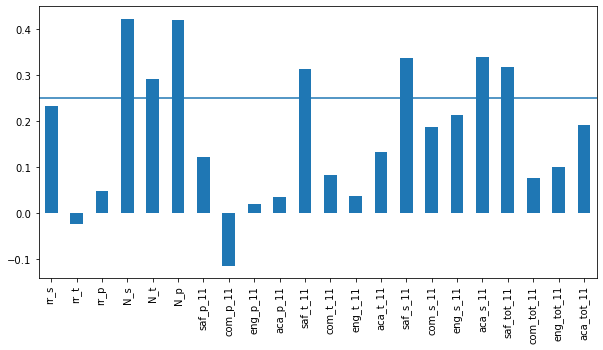

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
combined.corr()["sat_score"][survey_fields].plot.bar()
plt.axhline(0.25)  # Level for assessing correlation significance

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`.  Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.  

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`.  This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with `sat_score`.  This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

## Exploring Safety and SAT Scores

Below, we'll dig into how teachers and students perceive safety at school a bit more, and try to figure out which schools have low safety scores. 

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

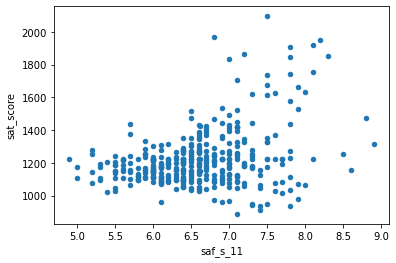

In [171]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it isn't that strong.  It looks like there are a few schools with extremely high SAT scores and high safety scores.  There are a few schools with low safety scores and low SAT scores.  No school with a safety score lower than `6.5` has an average SAT score higher than 1500 or so.

<AxesSubplot:xlabel='boro'>

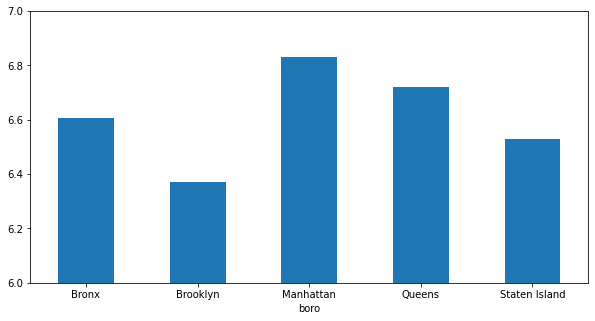

In [172]:
### Explore safety by borough
boros = combined.groupby("boro").agg(np.mean)["saf_s_11"]
plt.figure(figsize=(10, 5))
plt.ylim(6, 7)
boros.plot.bar(rot=0)

It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

- `white_per`


- `asian_per`


- `black_per`


- `hispanic_per`

By plotting out correlations between these columns and `sat_score`, we can determine whether there are any racial diffirences in SAT perfomance

<AxesSubplot:title={'center':'Correlation between average SAT score and race'}>

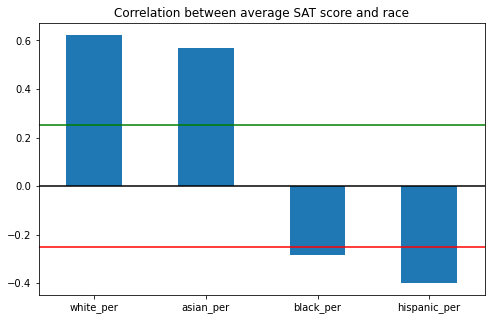

In [173]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
plt.figure(figsize=(8, 5))
plt.title('Correlation between average SAT score and race')
plt.axhline(0.25, c='green')
plt.axhline(-0.25, c='red')
plt.axhline(0, c='black')
combined.corr()["sat_score"][race_fields].plot.bar(rot=0)

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score.  This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

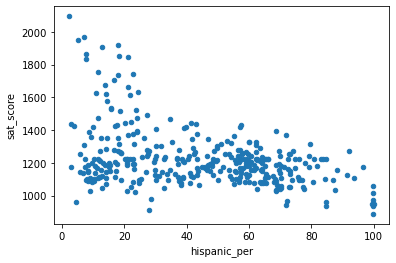

In [174]:
combined.plot.scatter("hispanic_per", "sat_score")

In [175]:
### Check school names where hispanic students predominate
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US.  These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [176]:
### Select schools with hispanic minority and high SAT results
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam.  This doesn't explain the low `hispanic_per`, but it does explain why their students tend to do better on the SAT - they are students from all over New York City who did well on a standardized test.

## Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:
- `male_per`


- `female_per`

We can plot out the correlations between each percentage and `sat_score`

<AxesSubplot:>

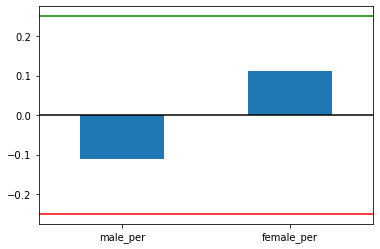

In [177]:
gender_fields = ["male_per", "female_per"]
plt.axhline(0.25, c='green')
plt.axhline(-0.25, c='red')
plt.axhline(0, c='black')
combined.corr()["sat_score"][gender_fields].plot.bar(rot=0)

In the plot above, we can see that a high percentage of females at a school slightly positively correlates with SAT score, and vice versa.  Both correlations have doubtful significance.

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

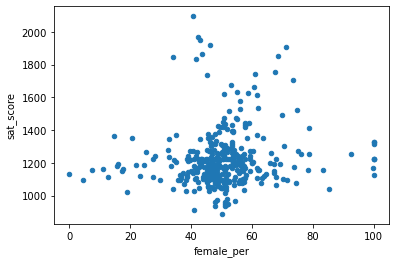

In [178]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between `sat_score` and `female_per`.  However, there is a cluster of schools with a high percentage of females (`60` to `80`), and high SAT scores.

In [179]:
### Select schools with female majority and high SAT scores
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

## Exploring AP Scores vs. SAT Scores

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

0.05717081390766952


<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

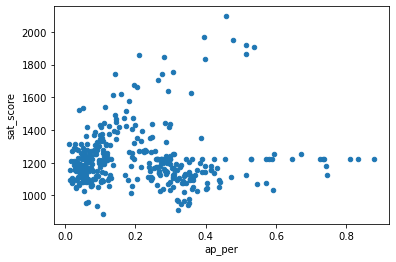

In [180]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

print(combined.corr()["ap_per"]['sat_score'])
combined.plot.scatter(x='ap_per', y='sat_score')

It doesn't look like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores.  The calculated correlation coefficient close to zero confirms this hypothesis.

## Exploring Class Size and SAT Scores

0.38101433080955277


<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

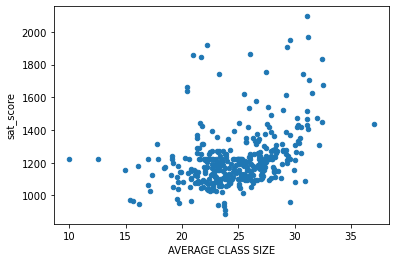

In [181]:
print(combined.corr()["sat_score"]['AVERAGE CLASS SIZE'])
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

Surprisingly, class size and SAT scores are highly correlated, despite the fact that in larger groups each individual student gets less attention. Perhaps in larger classes there is more cohesion, there are more opportunities to make friends and help each other.

## Exploring Borough and SAT Score

<AxesSubplot:xlabel='boro'>

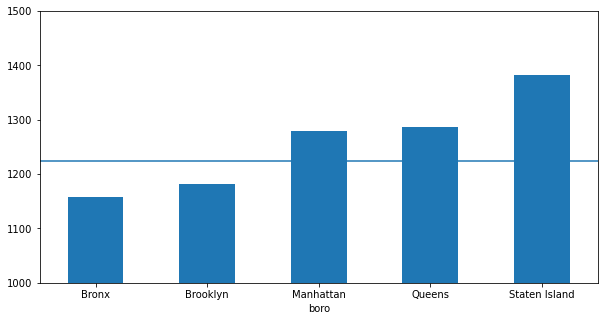

In [182]:
### Explore safety by borough
boros = combined.groupby("boro").agg(np.mean)["sat_score"]
plt.figure(figsize=(10, 5))
plt.axhline(np.mean(combined['sat_score']))  # horizontal line of average among all value
plt.ylim(1000, 1500)
boros.plot.bar(rot=0)

We can see Bronx and Brooklyn have less strong average results, Manhattan and Queens have medium, and Staten Island is prevailing with average SAT scores.

## Conclusion

We've done a bit of investigation into relationship between demographics and SAT scores in this project. We explored factors such as:

- Safety (high significance)


- Race (high significance)


- Gender (low significance)


- AP scores (high significance)


- Class size (high significance)


- Borough (high significance)